In [1]:
# Import needed libraries

import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys


print("Imported necessary libraries.")

Imported necessary libraries.


In [11]:
# Establish API connection

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = "1956e71b71d2447f8ea8061325a6683c"
client_secret = "a76b7c0d30f44d7f8c392a4a18d56098"

# Set up authorization
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

print("Established connection to Spotipy API.")

Established connection to Spotipy API.


In [15]:
token = auth_manager.get_access_token()
print(token)

{'access_token': 'BQBVUlyLQ4TiPauvrGLbLGX6xvJLhrigCetgPtxw4eMpoqNGa74hF2iZmBjJ47pQLDs-Xztvh_Apa3h0rxwbw_sPhmkNVJEYiEt9JLXgpcq-3QhXS5I', 'token_type': 'Bearer', 'expires_in': 3600, 'expires_at': 1733462411}


/var/folders/sv/67hlh2m91jnczt66yw3vcqf80000gp/T/ipykernel_62150/1177163314.py:1: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token = auth_manager.get_access_token()


In [3]:
# For all accounts, combine all json files in the export folder

paths = ['mmcmm', 'thing21']

for path in paths:

    # Path to the folder containing JSON files
    folder_path = 'rd/' + path + '/'  
    
    # List all JSON files in the folder
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    
    # Initialize an empty list to hold DataFrames
    dataframes = []
    
    # Loop through each JSON file and read it into a DataFrame
    for file in json_files:
        try:
            df = pd.read_json(file)  # Read JSON file into a DataFrame
            dataframes.append(df)    # Append the DataFrame to the list
        except ValueError as e:
            print(f"Error reading {file}: {e}")
    
    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dataframes, ignore_index=True)
    
    # Output the final DataFrame to a CSV file
    output_file = 'outputs/' + path + 'streams.csv'  
    final_df.to_csv(output_file, index=False)
    
    print(f"{path} data saved as {output_file}")

mmcmm data saved as outputs/mmcmmstreams.csv
thing21 data saved as outputs/thing21streams.csv


In [4]:
# Clean and combine data for all accounts

mmcmmdata = pd.read_csv('outputs/mmcmmstreams.csv', low_memory=False)
thing21data = pd.read_csv('outputs/thing21streams.csv', low_memory=False)

alldata = [mmcmmdata, thing21data]
names = ['mmcmm', 'thing21']

for idx, data in enumerate(alldata):
    # Perform data cleaning and transformations
    del data['user_agent_decrypted']
    data['ts'] = pd.to_datetime(data['ts'])
    data['skipped'] = data['skipped'].astype(bool)
    data['offline'] = data['offline'].astype(bool)
    data['incognito_mode'] = data['incognito_mode'].astype(bool)
    data['offline_timestamp'] = data['offline_timestamp'].replace([float('inf'), float('-inf')], None)
    data['offline_timestamp'] = data['offline_timestamp'].fillna(0)
    data['offline_timestamp'] = data['offline_timestamp'].astype(int)
    data['offline_timestamp'] = pd.to_datetime(data['offline_timestamp'], unit='s', errors='coerce')

# Concatenate all DataFrames into a single DataFrame
streams = pd.concat(alldata, ignore_index=True)

# Output the final DataFrame to a CSV file
output_name = 'outputs/combined.csv'  
streams.to_csv(output_name, index=False)

print(f"Combined CSV of all streams saved as {output_name}. Used in code as streams")

Combined CSV of all streams saved as outputs/combined.csv. Used in code as streams


In [5]:
# Top-level overview
display(streams.info())
display(streams.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318725 entries, 0 to 318724
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype              
---  ------                             --------------   -----              
 0   ts                                 318725 non-null  datetime64[ns, UTC]
 1   username                           318725 non-null  object             
 2   platform                           318725 non-null  object             
 3   ms_played                          318725 non-null  int64              
 4   conn_country                       318725 non-null  object             
 5   ip_addr_decrypted                  266127 non-null  object             
 6   master_metadata_track_name         313686 non-null  object             
 7   master_metadata_album_artist_name  313686 non-null  object             
 8   master_metadata_album_album_name   313686 non-null  object             
 9   spotify_track_uri                  31

None

,ms_played,offline_timestamp
count,3.187250e+05,147418
mean,1.909269e+05,1981-09-04 03:18:39.321134400
min,0.000000e+00,1875-07-09 19:57:35
25%,1.323860e+05,1970-01-01 00:00:00
50%,2.038800e+05,1970-01-01 00:00:00
75%,2.534130e+05,1970-01-01 00:00:01
max,6.164642e+06,2024-05-05 21:14:15
std,1.294697e+05,NaN


Top 20 Artists by Play Count:
master_metadata_album_artist_name
The Mountain Goats    12434
Bright Eyes           11984
The National           8122
Jimmy Eat World        5508
Conor Oberst           4814
Wilco                  3774
Big Thief              3555
Okkervil River         3437
The Front Bottoms      3413
The Hold Steady        3162
Vampire Weekend        2752
Los Campesinos!        2737
Modest Mouse           2588
Adrianne Lenker        2511
Bob Dylan              2324
The Cure               2280
Counting Crows         2215
Taylor Swift           2121
Sufjan Stevens         2119
Nico Stai              2115
Name: count, dtype: int64


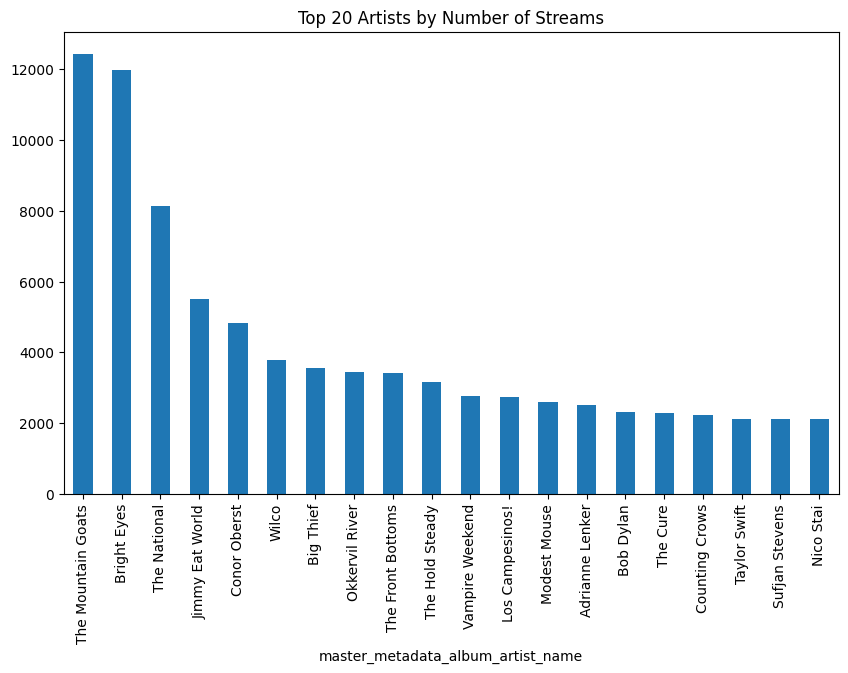

Top 20 Songs by Play Count:
master_metadata_track_name
Poison Oak                     381
At The Bottom Of Everything    371
Motorcycle Drive By            353
Jesus, Etc.                    344
Lua                            340
June On The West Coast         337
This Year                      308
Rill Rill                      305
First Day Of My Life           302
When I Go                      296
Two-Headed Boy                 293
Lost Coastlines                292
Dance Music                    285
Lucky Denver Mint              285
Mary                           275
You Can Call Me Al             267
Cape Canaveral                 265
Trailer Trash                  264
No Children                    258
Fast Car                       254
Name: count, dtype: int64


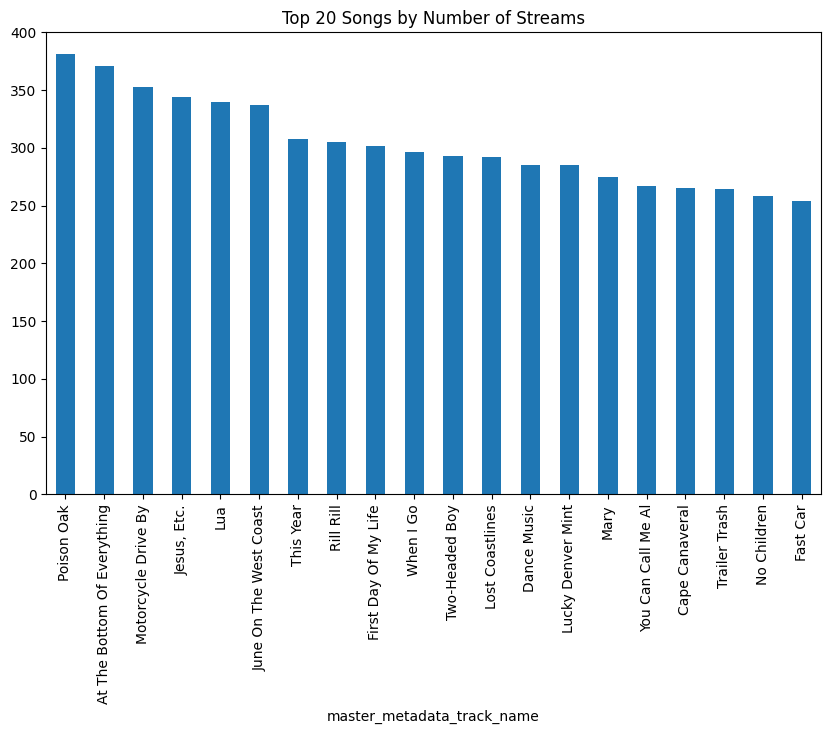

Top 20 Albums by Play Count:
master_metadata_album_album_name
I'm Wide Awake, It's Morning       2693
The Sunset Tree                    2101
Clarity                            1868
All Hail West Texas                1549
69 Love Songs                      1531
Greatest Hits                      1484
Capacity                           1480
Third Eye Blind                    1455
Trouble Will Find Me               1400
I Am Easy to Find                  1322
The Front Bottoms                  1260
Upside Down Mountain               1252
Romance Is Boring                  1228
Invented                           1183
August And Everything After        1172
Tallahassee                        1151
Summerteeth                        1144
In the Aeroplane Over the Sea      1110
Illinois                           1082
Yoshimi Battles the Pink Robots    1079
Name: count, dtype: int64


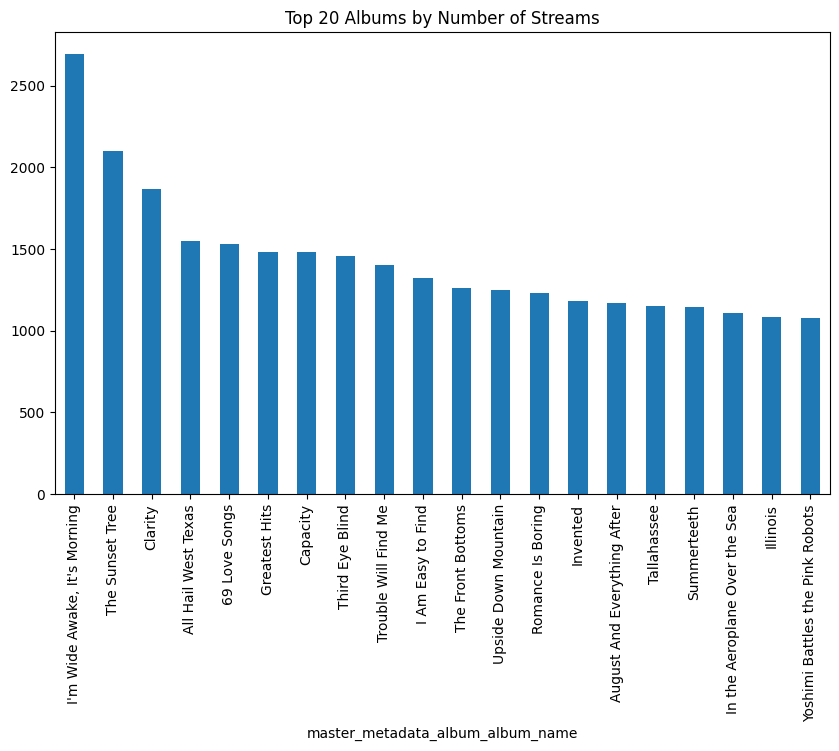

In [6]:
# lifetime rankings by streams
top_artists = streams['master_metadata_album_artist_name'].value_counts().head(20)
print("Top 20 Artists by Play Count:")
print(top_artists)

plt.figure(figsize=(10,6))
top_artists.plot(kind='bar')
plt.title("Top 20 Artists by Number of Streams")
plt.show()

top_songs = streams['master_metadata_track_name'].value_counts().head(20)
print("Top 20 Songs by Play Count:")
print(top_songs)

plt.figure(figsize=(10,6))
top_songs.plot(kind='bar')
plt.title("Top 20 Songs by Number of Streams")
plt.show()

top_albums = streams['master_metadata_album_album_name'].value_counts().head(20)
print("Top 20 Albums by Play Count:")
print(top_albums)

plt.figure(figsize=(10,6))
top_albums.plot(kind='bar')
plt.title("Top 20 Albums by Number of Streams")
plt.show()

Top 20 Artists by Total Play Duration (hours):
master_metadata_album_artist_name
Bright Eyes           736.724652
The Mountain Goats    554.994774
The National          497.304004
Jimmy Eat World       328.788020
Conor Oberst          277.875492
Okkervil River        252.501550
Wilco                 206.391958
Big Thief             184.382302
The Hold Steady       172.220414
The Front Bottoms     166.731899
Counting Crows        160.147253
Modest Mouse          154.492761
The Cure              152.177046
Bob Dylan             148.256939
Daft Punk             129.181308
Vampire Weekend       126.045494
Adrianne Lenker       123.207848
Third Eye Blind       118.011036
Craig Finn            117.945027
Los Campesinos!       116.023670
Name: ms_played, dtype: float64


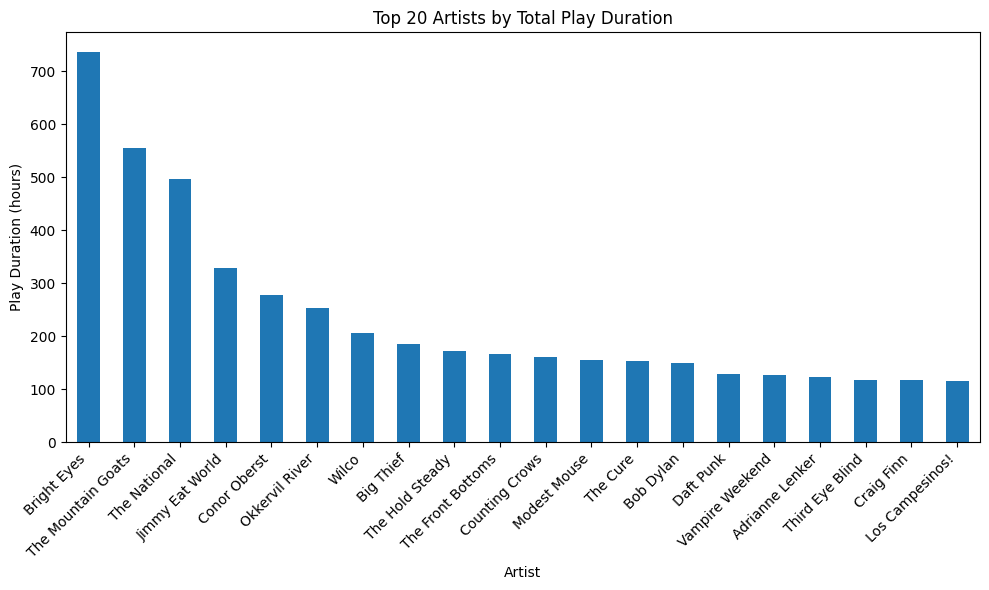

Top 20 Songs by Total Play Duration (hours):
master_metadata_track_name
Our Most Brilliant Friends     28.678355
Goodbye Sky Harbor             24.889912
At The Bottom Of Everything    24.776930
Poison Oak                     24.644165
Lua                            22.446537
Motorcycle Drive By            21.971605
Lost Coastlines                21.717961
Trailer Trash                  20.618075
Mary                           20.598918
Land Locked Blues              20.509589
Round Here                     18.683787
Romeo and Juliet               17.842182
Two-Headed Boy                 17.630867
Jesus, Etc.                    17.602762
Konstantine                    17.316443
Invented                       17.082264
American Pie                   16.497100
You Can Call Me Al             16.289283
June On The West Coast         16.262276
Fast Car                       16.194612
Name: ms_played, dtype: float64


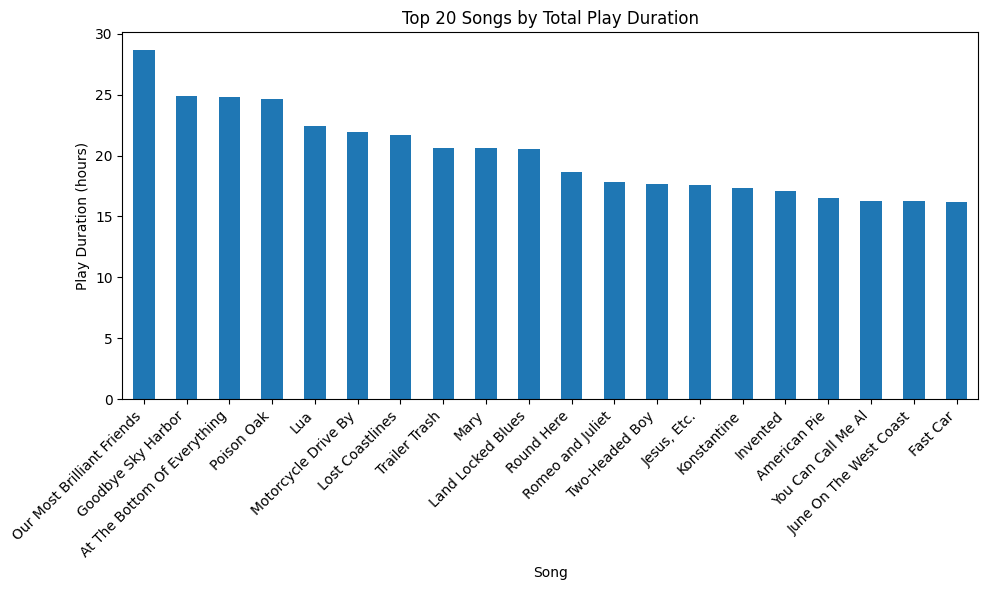

Top 20 Albums by Total Play Duration (hours):
master_metadata_album_album_name
I'm Wide Awake, It's Morning       173.933382
Clarity                            125.421436
Third Eye Blind                     92.035848
Disintegration                      88.326791
Trouble Will Find Me                87.845361
The Sunset Tree                     86.382949
August And Everything After         84.895981
Greatest Hits                       82.000293
Upside Down Mountain                80.693528
I Am Easy to Find                   78.268831
Capacity                            75.748346
The Lonesome Crowded West           70.493513
Cassadaga                           67.233597
Invented                            66.710466
Yoshimi Battles the Pink Robots     66.496508
The Front Bottoms                   65.585913
Letting Off The Happiness           65.428585
All Hail West Texas                 64.388408
To Pimp A Butterfly                 62.720879
Sleep Well Beast                    61.696930
N

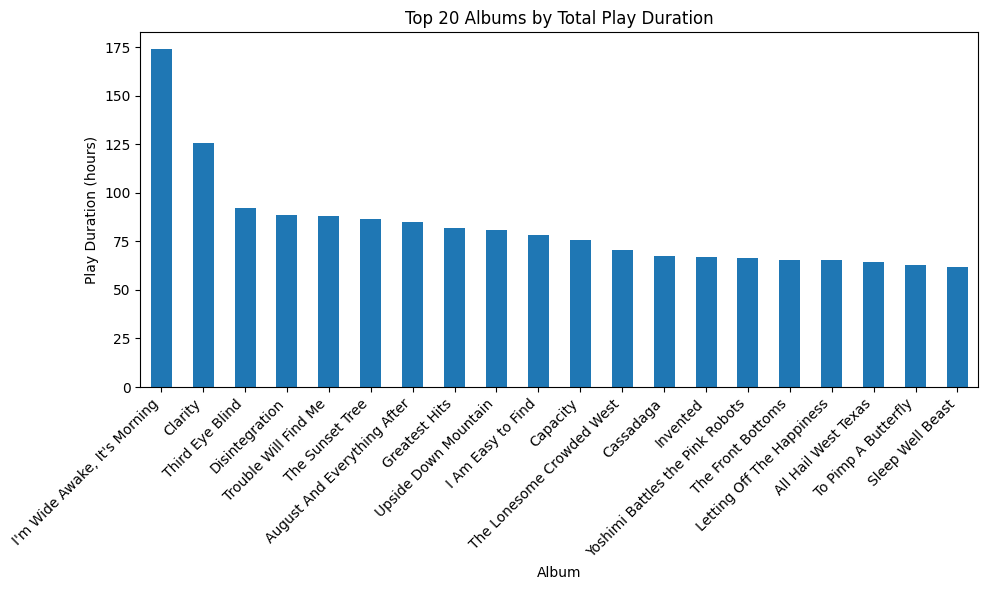

In [7]:
# lifetime rankings by duration

# Top Artists by Total Play Duration
top_artists = streams.groupby('master_metadata_album_artist_name')['ms_played'].sum().div(3600000).sort_values(ascending=False).head(20)
print("Top 20 Artists by Total Play Duration (hours):")
print(top_artists)

plt.figure(figsize=(10, 6))
top_artists.plot(kind='bar')
plt.title("Top 20 Artists by Total Play Duration")
plt.xlabel("Artist")
plt.ylabel("Play Duration (hours)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Top Songs by Total Play Duration
top_songs = streams.groupby('master_metadata_track_name')['ms_played'].sum().div(3600000).sort_values(ascending=False).head(20)
print("Top 20 Songs by Total Play Duration (hours):")
print(top_songs)

plt.figure(figsize=(10, 6))
top_songs.plot(kind='bar')
plt.title("Top 20 Songs by Total Play Duration")
plt.xlabel("Song")
plt.ylabel("Play Duration (hours)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Top Albums by Total Play Duration
top_albums = streams.groupby('master_metadata_album_album_name')['ms_played'].sum().div(3600000).sort_values(ascending=False).head(20)
print("Top 20 Albums by Total Play Duration (hours):")
print(top_albums)

plt.figure(figsize=(10, 6))
top_albums.plot(kind='bar')
plt.title("Top 20 Albums by Total Play Duration")
plt.xlabel("Album")
plt.ylabel("Play Duration (hours)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

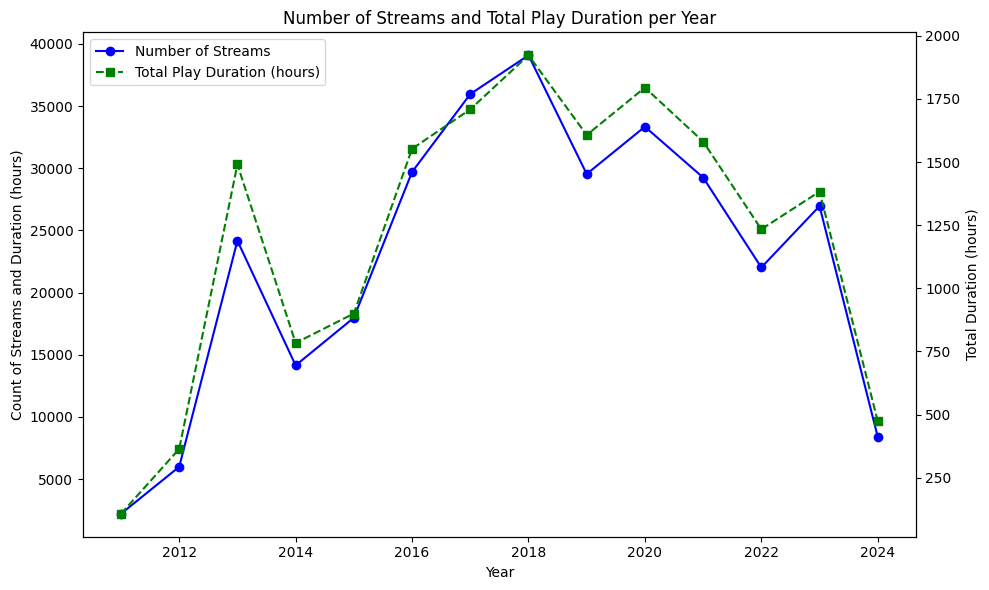

In [8]:
# Total play over lifetime

# Extracting time components
streams['year'] = streams['ts'].dt.year
streams['month'] = streams['ts'].dt.month

# Calculate total duration in hours per year
streams['hours_played'] = streams['ms_played'] / (1000 * 60 * 60)  # Convert ms to hours
yearly_duration = streams.groupby('year')['hours_played'].sum()

# Plotting the number of streams per year
yearly_counts = streams.groupby('year').size()
plt.figure(figsize=(10, 6))
yearly_counts.plot(marker='o', label='Number of Streams', color='blue')
plt.title("Number of Streams and Total Play Duration per Year")
plt.xlabel("Year")
plt.ylabel("Count of Streams and Duration (hours)")

# Plotting total play duration per year on a secondary y-axis
ax = plt.gca()
ax2 = ax.twinx()
yearly_duration.plot(marker='s', linestyle='--', label='Total Play Duration (hours)', color='green', ax=ax2)
ax2.set_ylabel("Total Duration (hours)")

# Combine legends
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()


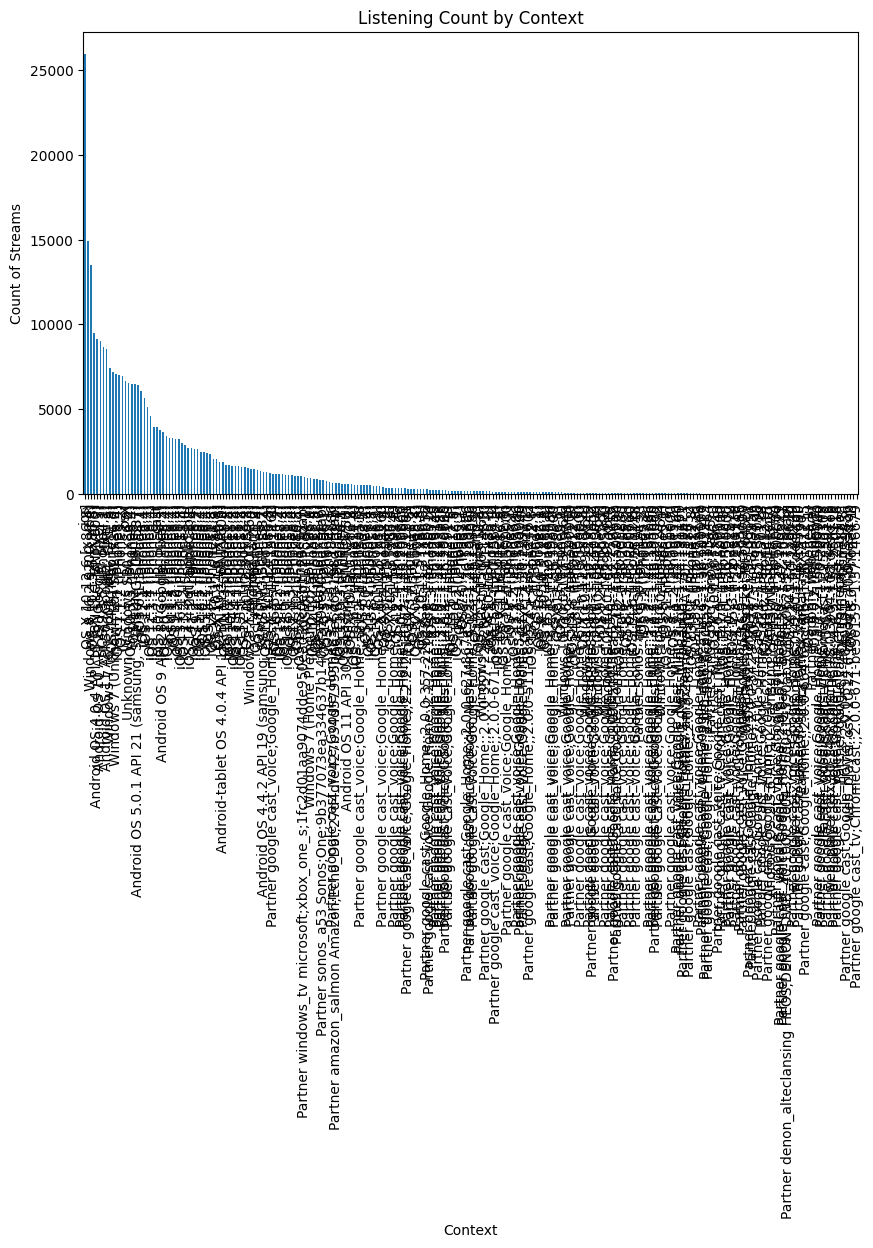

In [9]:
context_counts = streams['platform'].value_counts()
plt.figure(figsize=(10,6))
context_counts.plot(kind='bar')
plt.title("Listening Count by Context")
plt.xlabel("Context")
plt.ylabel("Count of Streams")
plt.show()

In [16]:
# Load your streams DataFrame before this code

track_uris = streams['spotify_track_uri'].unique().tolist()

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

output_file = "spotify_track_data.csv"

if not track_uris:
    print("No URIs provided.")
    sys.exit(1)

results = []

for i, uri_chunk in enumerate(chunks(track_uris, 50)):
    time.sleep(0.2)
    
    success = False
    attempts = 0
    while not success and attempts < 5:
        try:
            track_data = sp.tracks(uri_chunk)
            audio_data = sp.audio_features(uri_chunk)
            success = True
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.http_headers.get("Retry-After", 5))
                print(f"Rate limit hit. Waiting {retry_after} seconds...")
                time.sleep(retry_after)
            else:
                print(f"Error {e.http_status}: {e.msg}, retrying in 60s...")
                time.sleep(60)
            attempts += 1
        except Exception as e:
            print(f"Unknown error: {e}, retrying in 60s...")
            time.sleep(60)
            attempts += 1
    
    if not success:
        print(f"Failed to fetch data for {uri_chunk} after multiple attempts.")
        continue

    for t, a in zip(track_data['tracks'], audio_data):
        if t and a:
            results.append({
                'track_uri': t['uri'],
                'track_name': t['name'],
                'album_name': t['album']['name'],
                'album_release_date': t['album']['release_date'],
                'track_popularity': t['popularity'],
                'artist_names': [artist['name'] for artist in t['artists']],
                'danceability': a['danceability'],
                'energy': a['energy'],
                'loudness': a['loudness'],
                'tempo': a['tempo'],
                'valence': a['valence']
            })
    
    if i % 50 == 0 and i > 0:
        temp_df = pd.DataFrame(results)
        temp_df.to_csv(output_file, mode='a', header=not i, index=False)
        results = []
        print(f"Processed {i*50} tracks and saved to file.")

if results:
    final_df = pd.DataFrame(results)
    final_df.to_csv(output_file, mode='a', header=not i, index=False)

print("Data collection complete!")

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2kDhwX6rr3zcX5lQ34FwRu,2HbpYFQbairMoU2YFyOP2x,2P9nh9pTK96dE0b6NBbTSs,5jFqUtts2sSQsg5d7e42nI,0OWhKvvsHptt6vnnNUSM9a,11xeawurZXUDqRPxCasaDt,6W2PvnTNWUgxCJxRh84ALu,6K155OgCAeWxx4Be2kHkym,46z5wYDLxqBmqOvZro2EbE,1ldUPmqrCvk6thNYe0oUen,6k07Z7rd9og1FvRJD2n9E8,68i0Y8xMaYxLHSeUu4uWtA,4a1oIFgu01B2nafpOHgvHZ,4Oz6xl8qhJTdjYZeT98V4m,7EWDXdu3BzLLCuAGrAx4RT,5ORY1GDl3lpEDyU1CzSq26,7H0ya83CMmgFcOhw0UB6ow,2J2hSpUJ3aQXx81q2qqxMj,3ETUDzHZP3Ue3C767F9jxM,5JyJsAZyLTD7W5oWLeB0JK,55LqsLfv1S01SoVPbR8naN,3BYfQ3SIacPyf9DdmRlQMQ,7t8XA6K5ZqnPFoE375md3d,2oAXapw8YTR08jOHaDXJSW,1iOJzlWm2p8NOFYVHGGgq1,4Y890lKEqmv3JsTBijwekp,7C6VSVQYJR9LPNsD0qaTOa,4kJPG83yTGfZ9boQo6JyBG,4jCHG8GIVkKbJKXLyd3kLH,3i7mKjZKmslCFMxS1WM7DO,7lNmcW2wW6ciV9Rhh8YOMe,2gJj6WtAxXjApMs3PXsCeX,6b8LUVmacXlMUl4wRtCD2S,6QA2m3HgJaMF62jPguGMry,2kBamITd69LMvfYhkaSkaD,5ePiRipYivQM29vGNr3S1a,3FTtVJjqOSaDlM4FByo0RK,7y2mezWO3hkfyugI2s9WQp,1TsiwVwHhLgVK8sxBchINM,3dVLKe2i0nZmtOBBWBw9j4,7Cz3jTJOZkw

Error 403: https://api.spotify.com/v1/audio-features/?ids=2kDhwX6rr3zcX5lQ34FwRu,2HbpYFQbairMoU2YFyOP2x,2P9nh9pTK96dE0b6NBbTSs,5jFqUtts2sSQsg5d7e42nI,0OWhKvvsHptt6vnnNUSM9a,11xeawurZXUDqRPxCasaDt,6W2PvnTNWUgxCJxRh84ALu,6K155OgCAeWxx4Be2kHkym,46z5wYDLxqBmqOvZro2EbE,1ldUPmqrCvk6thNYe0oUen,6k07Z7rd9og1FvRJD2n9E8,68i0Y8xMaYxLHSeUu4uWtA,4a1oIFgu01B2nafpOHgvHZ,4Oz6xl8qhJTdjYZeT98V4m,7EWDXdu3BzLLCuAGrAx4RT,5ORY1GDl3lpEDyU1CzSq26,7H0ya83CMmgFcOhw0UB6ow,2J2hSpUJ3aQXx81q2qqxMj,3ETUDzHZP3Ue3C767F9jxM,5JyJsAZyLTD7W5oWLeB0JK,55LqsLfv1S01SoVPbR8naN,3BYfQ3SIacPyf9DdmRlQMQ,7t8XA6K5ZqnPFoE375md3d,2oAXapw8YTR08jOHaDXJSW,1iOJzlWm2p8NOFYVHGGgq1,4Y890lKEqmv3JsTBijwekp,7C6VSVQYJR9LPNsD0qaTOa,4kJPG83yTGfZ9boQo6JyBG,4jCHG8GIVkKbJKXLyd3kLH,3i7mKjZKmslCFMxS1WM7DO,7lNmcW2wW6ciV9Rhh8YOMe,2gJj6WtAxXjApMs3PXsCeX,6b8LUVmacXlMUl4wRtCD2S,6QA2m3HgJaMF62jPguGMry,2kBamITd69LMvfYhkaSkaD,5ePiRipYivQM29vGNr3S1a,3FTtVJjqOSaDlM4FByo0RK,7y2mezWO3hkfyugI2s9WQp,1TsiwVwHhLgVK8sxBchINM,3dVLKe2i0nZmtOBBWBw9j4,7Cz3jTJOZkwU0WCKBTDWLP

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2kDhwX6rr3zcX5lQ34FwRu,2HbpYFQbairMoU2YFyOP2x,2P9nh9pTK96dE0b6NBbTSs,5jFqUtts2sSQsg5d7e42nI,0OWhKvvsHptt6vnnNUSM9a,11xeawurZXUDqRPxCasaDt,6W2PvnTNWUgxCJxRh84ALu,6K155OgCAeWxx4Be2kHkym,46z5wYDLxqBmqOvZro2EbE,1ldUPmqrCvk6thNYe0oUen,6k07Z7rd9og1FvRJD2n9E8,68i0Y8xMaYxLHSeUu4uWtA,4a1oIFgu01B2nafpOHgvHZ,4Oz6xl8qhJTdjYZeT98V4m,7EWDXdu3BzLLCuAGrAx4RT,5ORY1GDl3lpEDyU1CzSq26,7H0ya83CMmgFcOhw0UB6ow,2J2hSpUJ3aQXx81q2qqxMj,3ETUDzHZP3Ue3C767F9jxM,5JyJsAZyLTD7W5oWLeB0JK,55LqsLfv1S01SoVPbR8naN,3BYfQ3SIacPyf9DdmRlQMQ,7t8XA6K5ZqnPFoE375md3d,2oAXapw8YTR08jOHaDXJSW,1iOJzlWm2p8NOFYVHGGgq1,4Y890lKEqmv3JsTBijwekp,7C6VSVQYJR9LPNsD0qaTOa,4kJPG83yTGfZ9boQo6JyBG,4jCHG8GIVkKbJKXLyd3kLH,3i7mKjZKmslCFMxS1WM7DO,7lNmcW2wW6ciV9Rhh8YOMe,2gJj6WtAxXjApMs3PXsCeX,6b8LUVmacXlMUl4wRtCD2S,6QA2m3HgJaMF62jPguGMry,2kBamITd69LMvfYhkaSkaD,5ePiRipYivQM29vGNr3S1a,3FTtVJjqOSaDlM4FByo0RK,7y2mezWO3hkfyugI2s9WQp,1TsiwVwHhLgVK8sxBchINM,3dVLKe2i0nZmtOBBWBw9j4,7Cz3jTJOZkw

Error 403: https://api.spotify.com/v1/audio-features/?ids=2kDhwX6rr3zcX5lQ34FwRu,2HbpYFQbairMoU2YFyOP2x,2P9nh9pTK96dE0b6NBbTSs,5jFqUtts2sSQsg5d7e42nI,0OWhKvvsHptt6vnnNUSM9a,11xeawurZXUDqRPxCasaDt,6W2PvnTNWUgxCJxRh84ALu,6K155OgCAeWxx4Be2kHkym,46z5wYDLxqBmqOvZro2EbE,1ldUPmqrCvk6thNYe0oUen,6k07Z7rd9og1FvRJD2n9E8,68i0Y8xMaYxLHSeUu4uWtA,4a1oIFgu01B2nafpOHgvHZ,4Oz6xl8qhJTdjYZeT98V4m,7EWDXdu3BzLLCuAGrAx4RT,5ORY1GDl3lpEDyU1CzSq26,7H0ya83CMmgFcOhw0UB6ow,2J2hSpUJ3aQXx81q2qqxMj,3ETUDzHZP3Ue3C767F9jxM,5JyJsAZyLTD7W5oWLeB0JK,55LqsLfv1S01SoVPbR8naN,3BYfQ3SIacPyf9DdmRlQMQ,7t8XA6K5ZqnPFoE375md3d,2oAXapw8YTR08jOHaDXJSW,1iOJzlWm2p8NOFYVHGGgq1,4Y890lKEqmv3JsTBijwekp,7C6VSVQYJR9LPNsD0qaTOa,4kJPG83yTGfZ9boQo6JyBG,4jCHG8GIVkKbJKXLyd3kLH,3i7mKjZKmslCFMxS1WM7DO,7lNmcW2wW6ciV9Rhh8YOMe,2gJj6WtAxXjApMs3PXsCeX,6b8LUVmacXlMUl4wRtCD2S,6QA2m3HgJaMF62jPguGMry,2kBamITd69LMvfYhkaSkaD,5ePiRipYivQM29vGNr3S1a,3FTtVJjqOSaDlM4FByo0RK,7y2mezWO3hkfyugI2s9WQp,1TsiwVwHhLgVK8sxBchINM,3dVLKe2i0nZmtOBBWBw9j4,7Cz3jTJOZkwU0WCKBTDWLP

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=2kDhwX6rr3zcX5lQ34FwRu,2HbpYFQbairMoU2YFyOP2x,2P9nh9pTK96dE0b6NBbTSs,5jFqUtts2sSQsg5d7e42nI,0OWhKvvsHptt6vnnNUSM9a,11xeawurZXUDqRPxCasaDt,6W2PvnTNWUgxCJxRh84ALu,6K155OgCAeWxx4Be2kHkym,46z5wYDLxqBmqOvZro2EbE,1ldUPmqrCvk6thNYe0oUen,6k07Z7rd9og1FvRJD2n9E8,68i0Y8xMaYxLHSeUu4uWtA,4a1oIFgu01B2nafpOHgvHZ,4Oz6xl8qhJTdjYZeT98V4m,7EWDXdu3BzLLCuAGrAx4RT,5ORY1GDl3lpEDyU1CzSq26,7H0ya83CMmgFcOhw0UB6ow,2J2hSpUJ3aQXx81q2qqxMj,3ETUDzHZP3Ue3C767F9jxM,5JyJsAZyLTD7W5oWLeB0JK,55LqsLfv1S01SoVPbR8naN,3BYfQ3SIacPyf9DdmRlQMQ,7t8XA6K5ZqnPFoE375md3d,2oAXapw8YTR08jOHaDXJSW,1iOJzlWm2p8NOFYVHGGgq1,4Y890lKEqmv3JsTBijwekp,7C6VSVQYJR9LPNsD0qaTOa,4kJPG83yTGfZ9boQo6JyBG,4jCHG8GIVkKbJKXLyd3kLH,3i7mKjZKmslCFMxS1WM7DO,7lNmcW2wW6ciV9Rhh8YOMe,2gJj6WtAxXjApMs3PXsCeX,6b8LUVmacXlMUl4wRtCD2S,6QA2m3HgJaMF62jPguGMry,2kBamITd69LMvfYhkaSkaD,5ePiRipYivQM29vGNr3S1a,3FTtVJjqOSaDlM4FByo0RK,7y2mezWO3hkfyugI2s9WQp,1TsiwVwHhLgVK8sxBchINM,3dVLKe2i0nZmtOBBWBw9j4,7Cz3jTJOZkw

Error 403: https://api.spotify.com/v1/audio-features/?ids=2kDhwX6rr3zcX5lQ34FwRu,2HbpYFQbairMoU2YFyOP2x,2P9nh9pTK96dE0b6NBbTSs,5jFqUtts2sSQsg5d7e42nI,0OWhKvvsHptt6vnnNUSM9a,11xeawurZXUDqRPxCasaDt,6W2PvnTNWUgxCJxRh84ALu,6K155OgCAeWxx4Be2kHkym,46z5wYDLxqBmqOvZro2EbE,1ldUPmqrCvk6thNYe0oUen,6k07Z7rd9og1FvRJD2n9E8,68i0Y8xMaYxLHSeUu4uWtA,4a1oIFgu01B2nafpOHgvHZ,4Oz6xl8qhJTdjYZeT98V4m,7EWDXdu3BzLLCuAGrAx4RT,5ORY1GDl3lpEDyU1CzSq26,7H0ya83CMmgFcOhw0UB6ow,2J2hSpUJ3aQXx81q2qqxMj,3ETUDzHZP3Ue3C767F9jxM,5JyJsAZyLTD7W5oWLeB0JK,55LqsLfv1S01SoVPbR8naN,3BYfQ3SIacPyf9DdmRlQMQ,7t8XA6K5ZqnPFoE375md3d,2oAXapw8YTR08jOHaDXJSW,1iOJzlWm2p8NOFYVHGGgq1,4Y890lKEqmv3JsTBijwekp,7C6VSVQYJR9LPNsD0qaTOa,4kJPG83yTGfZ9boQo6JyBG,4jCHG8GIVkKbJKXLyd3kLH,3i7mKjZKmslCFMxS1WM7DO,7lNmcW2wW6ciV9Rhh8YOMe,2gJj6WtAxXjApMs3PXsCeX,6b8LUVmacXlMUl4wRtCD2S,6QA2m3HgJaMF62jPguGMry,2kBamITd69LMvfYhkaSkaD,5ePiRipYivQM29vGNr3S1a,3FTtVJjqOSaDlM4FByo0RK,7y2mezWO3hkfyugI2s9WQp,1TsiwVwHhLgVK8sxBchINM,3dVLKe2i0nZmtOBBWBw9j4,7Cz3jTJOZkwU0WCKBTDWLP

KeyboardInterrupt: 